In [1]:
import os
import time
from PIL import Image
import pickle
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import open3d as o3d
import json

import utils

In [2]:
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

### Specify training and test directory

In [3]:
training_data_dir = "../data/pose_dataset/training_data/v2.2"
train_val_split_dir = "../data/pose_dataset/training_data/splits/v2"

test_data_dir = "../data/pose_dataset/testing_data/v2.2"
test_split_dir = "../data/pose_dataset/testing_data"

In [4]:
def get_split_files(data_dir, split_dir, split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

### Store the train file paths

In [5]:
train_rgb_files, train_depth_files, train_label_files, train_meta_files = get_split_files(training_data_dir, 
                                                                                          train_val_split_dir, 'train')
num_train_files = len(train_rgb_files)
print("Number of Training files:", num_train_files)

Number of Training files: 3964


### Store the validation file paths

In [6]:
val_rgb_files, val_depth_files, val_label_files, val_meta_files = get_split_files(training_data_dir, 
                                                                                  train_val_split_dir, 'val')
num_val_files = len(val_rgb_files)
print("Number of Validation files:", num_val_files)

Number of Validation files: 236


### Store the test file paths

In [7]:
test_rgb_files, test_depth_files, test_label_files, test_meta_files = get_split_files(test_data_dir, 
                                                                                      test_split_dir, 'test')
num_test_files = len(test_rgb_files)
print("Number of Test files:", num_test_files)

Number of Test files: 200


In [23]:
NUM_OBJECTS = 79
INCLUDE_SCALE = True

cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

In [9]:
def compute_world_coord(loc_v, loc_u, depth_img, extrinsic_mat, intrinsic_mat):
    assert(loc_v.shape == loc_u.shape)
    num_pts = loc_v.shape[0]      # = N
    depth = depth_img[loc_v, loc_u]
    
    x_dash = np.multiply(loc_u + 0.5, depth)
    y_dash = np.multiply(loc_v + 0.5, depth)
    
    film_coord = np.array([x_dash, y_dash, depth])   # (3,N)
    cam_coord = np.matmul(np.linalg.inv(intrinsic_mat), film_coord)  # (3,N)
    cam_coord = np.vstack([cam_coord, np.ones((num_pts,))])   # (4,N)

    world_coord = np.matmul(np.linalg.inv(extrinsic_mat), cam_coord)   # (4,N)
#     print(loc_v.shape, loc_u.shape, depth.shape, film_coord.shape, cam_coord.shape, world_coord.shape)
    
    return world_coord

### Iterate over training data and store all training data in a pickle file

In [10]:
# dict_train_data = {}
# dict_train_data["depth_img"] = []
# dict_train_data["label_img"] = []
# dict_train_data["metadata"] = []

# for i in tqdm(range(num_train_files)):
#     dict_train_data["depth_img"].append(np.array(Image.open(train_depth_files[i])) / 1000)
#     dict_train_data["label_img"].append(np.array(Image.open(train_label_files[i])))
#     dict_train_data["metadata"].append(load_pickle(train_meta_files[i]))

# # store the data into pickle file
# with open('../data/pkl_files/train_data_pkl.pickle', 'wb') as handle:
#     pickle.dump(dict_train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Iteration over training data to extract PCD for all instances of all objects

In [11]:
# with open('../data/pkl_files/train_data_pkl.pickle', 'rb') as handle:
#     dict_train_data = pickle.load(handle)

dict_obj_pcd = {}
dict_obj_GT_trans = {}

for key in range(NUM_OBJECTS):
    dict_obj_pcd[key] = []
    dict_obj_GT_trans[key] = []

start_time = time.time()

# iterate over the training data and load training images
for i in tqdm(range(num_train_files)):
    depth_img = np.array(Image.open(train_depth_files[i])) / 1000
    label_img = np.array(Image.open(train_label_files[i]))
    metadata = load_pickle(train_meta_files[i])

    scale_lst = metadata['scales']
    
    for object_id in metadata['object_ids']:
        loc_v, loc_u = np.where(label_img == object_id)
        world_coord = compute_world_coord(loc_v, loc_u, depth_img, metadata['extrinsic'], metadata['intrinsic'])
        
        if INCLUDE_SCALE:
            world_coord[0:3] = np.multiply(world_coord[0:3], np.reshape(1.0/scale_lst[object_id], (3,1)))
            metadata['poses_world'][object_id][0:3,3] = np.multiply(metadata['poses_world'][object_id][0:3,3], 
                                                                    1.0/scale_lst[object_id])
        
        # transform world coord using GT pose given
        world_coord = np.matmul(np.linalg.inv(metadata['poses_world'][object_id]), world_coord)   # (4,N)

        dict_obj_pcd[object_id].append(world_coord[0:3])
        dict_obj_GT_trans[object_id].append(metadata['poses_world'][object_id])

#         rgb_img[loc_v, loc_u] = 0.0
#         plt.figure(figsize=(15, 10))
#         plt.imshow(rgb_img)
#         break

print("Time taken to extract pcd from train data:", round(time.time() - start_time, 3), 's')

# store the data into pickle file
with open('../data/pkl_files/dict_pcd_unscaled.pickle', 'wb') as handle:
    pickle.dump(dict_obj_pcd, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/pkl_files/dict_GT_trans_unscaled.pickle', 'wb') as handle:
    pickle.dump(dict_obj_GT_trans, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/3964 [00:00<?, ?it/s]

Time taken to extract pcd from train data: 304.629 s


### Load pickle file storing the dictionary of pcd extracted from training data

In [24]:
with open('../data/pkl_files/dict_pcd.pickle', 'rb') as handle:
    dict_obj_pcd = pickle.load(handle)

with open('../data/pkl_files/dict_GT_trans.pickle', 'rb') as handle:
    dict_obj_GT_trans = pickle.load(handle)

### Iterate over test data and store all test data in a pickle file

In [15]:
dict_test_data = {}
dict_test_data["depth_img"] = []
dict_test_data["label_img"] = []
dict_test_data["metadata"] = []

for i in tqdm(range(num_test_files)):
    dict_test_data["depth_img"].append(np.array(Image.open(test_depth_files[i])) / 1000)
    dict_test_data["label_img"].append(np.array(Image.open(test_label_files[i])))
    dict_test_data["metadata"].append(load_pickle(test_meta_files[i]))

# store the data into pickle file
with open('../data/pkl_files/test_data_pkl.pickle', 'wb') as handle:
    pickle.dump(dict_test_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/200 [00:00<?, ?it/s]

### Load test data from pickle file

In [25]:
with open('../data/pkl_files/test_data_pkl.pickle', 'rb') as handle:
    dict_test_data = pickle.load(handle)

## Iteration over test data to estimate the pose of each instance of an object in every scene

In [19]:
### Create json dictionary for storing output transformations
json_poses_dict = {}

with open(os.path.join(test_split_dir, f"test.txt"), 'r') as f:
    test_file_prefix = [line.strip() for line in f if line.strip()]

for keys in test_file_prefix:
    json_poses_dict[keys] = {"poses_world": [None]*NUM_OBJECTS}

DOWNSAMPLE = 2
ICP_THRESH = 0.01

start_time = time.time()

src_pcd = o3d.geometry.PointCloud()
tgt_pcd = o3d.geometry.PointCloud()

# iterate over the test data and load test images
for i in tqdm(range(num_test_files)):
    depth_img = dict_test_data["depth_img"][i]
    label_img = dict_test_data["label_img"][i]
    metadata = dict_test_data["metadata"][i]
    
    for object_id in metadata['object_ids']:
        loc_v, loc_u = np.where(label_img == object_id)

        if loc_v.shape[0] > 0:
            world_coord = compute_world_coord(loc_v, loc_u, depth_img, metadata['extrinsic'], metadata['intrinsic'])  # (4,N)
            
            if INCLUDE_SCALE:
                world_coord[0:3] = np.multiply(world_coord[0:3], np.reshape(1.0/metadata['scales'][object_id], (3,1)))
            
            tgt_pcd_np = np.transpose(np.copy(world_coord[0:3, ::DOWNSAMPLE]))   # (N//DOWNSAMPLE, 3)

            # convert source and target pcd to open3d format
            tgt_pcd.points = o3d.utility.Vector3dVector(tgt_pcd_np)

            num_pcd_per_obj = len(dict_obj_pcd[object_id])

            fitness_lst = []
            transformations_lst = []

            for j in range(num_pcd_per_obj):
                init_trans = dict_obj_GT_trans[object_id][j]

                src_pcd_np = np.transpose(dict_obj_pcd[object_id][j][:, ::DOWNSAMPLE])
                
                src_pcd.points = o3d.utility.Vector3dVector(src_pcd_np)

                # Apply point-to-point ICP
                reg_p2p = o3d.pipelines.registration.registration_icp(
                    src_pcd, tgt_pcd, ICP_THRESH, init_trans,
                    o3d.pipelines.registration.TransformationEstimationPointToPoint(), 
                    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration = 50))
                
#                 reg_p2p = o3d.pipelines.registration.registration_icp(
#                     src_pcd, tgt_pcd, ICP_THRESH, init_trans,
#                     o3d.pipelines.registration.TransformationEstimationPointToPlane())

                fitness_lst.append(reg_p2p.fitness)
                transformations_lst.append(np.copy(reg_p2p.transformation))
        
            opt_transformation = transformations_lst[np.argmax(fitness_lst)]   # (4,4)
        else:
            opt_transformation = np.eye(4)
        
        if INCLUDE_SCALE:
            opt_transformation[0:3,3] = np.multiply(opt_transformation[0:3,3], metadata['scales'][object_id])
        
        json_poses_dict[test_file_prefix[i]]["poses_world"][object_id] = opt_transformation.tolist()

#     if i > 1:
#         break

print("Time taken to estimate transforms for test data:", round(time.time() - start_time, 3), 's')

JSON_FILE_PATH = os.path.join("../data/json_files", f'pred_test_{DOWNSAMPLE}_{ICP_THRESH}.json')
with open(JSON_FILE_PATH, 'w') as f:
    json.dump(json_poses_dict, f)

  0%|          | 0/200 [00:00<?, ?it/s]

Time taken to estimate transforms for test data: 669.801 s


### Iterate over validation data and store all data in pickle files

In [13]:
dict_val_data = {}
dict_val_data["depth_img"] = []
dict_val_data["label_img"] = []
dict_val_data["metadata"] = []

for i in tqdm(range(num_val_files)):
    dict_val_data["depth_img"].append(np.array(Image.open(val_depth_files[i])) / 1000)
    dict_val_data["label_img"].append(np.array(Image.open(val_label_files[i])))
    dict_val_data["metadata"].append(load_pickle(val_meta_files[i]))

# store the data into pickle file
with open('../data/pkl_files/val_data_pkl.pickle', 'wb') as handle:
    pickle.dump(dict_val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/236 [00:00<?, ?it/s]

### Load validation data from pickle file

In [12]:
with open('../data/pkl_files/val_data_pkl.pickle', 'rb') as handle:
    dict_val_data = pickle.load(handle)

## Iteration over Validation data to estimate the pose of each instance of an object in every scene

In [29]:
### Create json dictionary for storing output transformations
json_poses_dict = {}

with open(os.path.join(train_val_split_dir, f"val.txt"), 'r') as f:
    test_file_prefix = [line.strip() for line in f if line.strip()]

for keys in test_file_prefix:
    json_poses_dict[keys] = {"poses_world": [None]*NUM_OBJECTS}

DOWNSAMPLE = 64
ICP_THRESH = 0.01

start_time = time.time()

src_pcd = o3d.geometry.PointCloud()
tgt_pcd = o3d.geometry.PointCloud()

# iterate over the validation data and load test images
for i in tqdm(range(num_val_files)):
    depth_img = dict_val_data["depth_img"][i]
    label_img = dict_val_data["label_img"][i]
    metadata = dict_val_data["metadata"][i]
    
    for object_id in metadata['object_ids']:
        loc_v, loc_u = np.where(label_img == object_id)

        if loc_v.shape[0] > 0:
            world_coord = compute_world_coord(loc_v, loc_u, depth_img, metadata['extrinsic'], metadata['intrinsic'])  # (4,N)
            
            if INCLUDE_SCALE:
                world_coord[0:3] = np.multiply(world_coord[0:3], np.reshape(1.0/metadata['scales'][object_id], (3,1)))
            
            tgt_pcd_np = np.transpose(np.copy(world_coord[0:3, ::DOWNSAMPLE]))   # (N//DOWNSAMPLE, 3)

            # convert source and target pcd to open3d format
            tgt_pcd.points = o3d.utility.Vector3dVector(tgt_pcd_np)

            num_pcd_per_obj = len(dict_obj_pcd[object_id])

            fitness_lst = []
            transformations_lst = []

            for j in range(num_pcd_per_obj):
                init_trans = dict_obj_GT_trans[object_id][j]

                src_pcd_np = np.transpose(dict_obj_pcd[object_id][j][:, ::DOWNSAMPLE])
                
                src_pcd.points = o3d.utility.Vector3dVector(src_pcd_np)
                
                # Apply point-to-point ICP
                reg_p2p = o3d.pipelines.registration.registration_icp(
                    src_pcd, tgt_pcd, ICP_THRESH, init_trans,
                    o3d.pipelines.registration.TransformationEstimationPointToPoint(), 
                    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration = 50))
                
#                 reg_p2p = o3d.pipelines.registration.registration_icp(
#                     src_pcd, tgt_pcd, ICP_THRESH, init_trans,
#                     o3d.pipelines.registration.TransformationEstimationPointToPlane())

                fitness_lst.append(reg_p2p.fitness)
                transformations_lst.append(np.copy(reg_p2p.transformation))
        
            opt_transformation = transformations_lst[np.argmax(fitness_lst)]   # (4,4)
        else:
            opt_transformation = np.eye(4)
        
        if INCLUDE_SCALE:
            opt_transformation[0:3,3] = np.multiply(opt_transformation[0:3,3], metadata['scales'][object_id])
        
        json_poses_dict[test_file_prefix[i]]["poses_world"][object_id] = opt_transformation.tolist()

#     if i > 1:
#         break

print("Time taken to estimate transforms for val data:", round(time.time() - start_time, 3), 's')

JSON_FILE_PATH = os.path.join("../data/json_files", f'pred_val_{DOWNSAMPLE}_{ICP_THRESH}.json')
with open(JSON_FILE_PATH, 'w') as f:
    json.dump(json_poses_dict, f)

  0%|          | 0/236 [00:00<?, ?it/s]

Time taken to estimate transforms for val data: 718.434 s


In [31]:
import benchmark_utils.benchmark as benchmark

benchmark.main()

## Get familiar with the data

[[6.007 6.003 5.999 ... 3.203 3.202 3.201]
 [5.975 5.971 5.967 ... 3.194 3.193 3.192]
 [5.944 5.94  5.936 ... 3.185 3.184 3.183]
 ...
 [1.251 1.25  1.25  ... 1.058 1.058 1.057]
 [1.249 1.249 1.249 ... 1.057 1.057 1.056]
 [1.248 1.248 1.247 ... 1.056 1.056 1.056]]
6.007 0.498
1.0 0.0
[[80 80 80 ... 80 80 80]
 [80 80 80 ... 80 80 80]
 [80 80 80 ... 80 80 80]
 ...
 [80 80 80 ... 80 80 80]
 [80 80 80 ... 80 80 80]
 [80 80 80 ... 80 80 80]]
[35 39 48 51 58 79 80 81]
(720, 1280, 3) (720, 1280) (720, 1280)


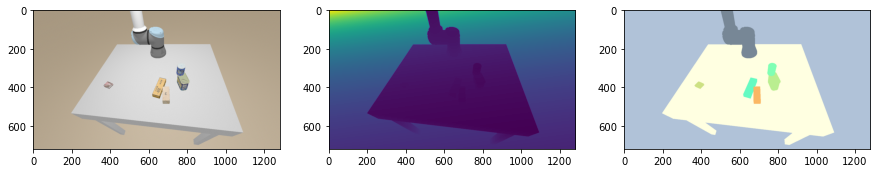

In [29]:
rgb = np.array(Image.open(train_rgb_files[0])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(train_depth_files[0])) / 1000   # convert from mm to m
label = np.array(Image.open(train_label_files[0]))

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [26]:
for i in range(num_val_files):
    meta = load_pickle(val_meta_files[i])
#     print(meta.keys())

#     print(meta['object_ids'])
#     for object_id in meta['object_ids']:
#         print(meta['poses_world'][object_id])
#     print(len(meta['poses_world'])) # 79

#     print(len(meta['extents']))
#     print(len(meta['scales']))

#     print(meta['object_ids'])    # list of objects ids in the scene
#     print(meta['object_names'])

#     print(meta['extrinsic'].shape)   # (4,4)
#     print(meta['intrinsic'].shape)   # (3,3)
    
#     print(meta['extrinsic'])
#     print(meta['intrinsic'])

    print(meta['scales'])

    break

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, array([1., 1., 1.], dtype=float32), None, None, None, array([0.5, 0.5, 0.5], dtype=float32), None, None, None, None, None, None, None, None, array([1., 1., 1.], dtype=float32), None, None, array([0.5, 0.5, 0.5], dtype=float32), None, None, None, None, None, None, array([0.5, 0.5, 0.5], dtype=float32), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [40]:
poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
print(poses_world.shape)
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])  # len, wid, hei
print(box_sizes.shape)

(10, 4, 4)
(10, 3)


## Lift depth to point cloud

In [61]:
time_m1 = 0
time_m2 = 0

for file in tqdm(range(num_train_files//10)):
    depth = np.array(Image.open(train_depth_files[file])) / 1000   # convert from mm to m
    label = np.array(Image.open(train_label_files[file]))
    metadata = load_pickle(train_meta_files[file])

    extrinsic_mat = metadata['extrinsic']
    intrinsic_mat = metadata['intrinsic']

    uniq_object_ids = metadata['object_ids']
    num_uniq_objects = len(uniq_object_ids)

    start_time = time.time()
    # method-2
    z = depth   # (H,W)
    v, u = np.indices(z.shape)  # (H,W), (H,W)
    uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)  # (H, W, 3)
    points_viewer = uv1 @ np.linalg.inv(intrinsic_mat).T * z[..., None]  # [H, W, 3]
    time_m2 += time.time() - start_time

    # method-1
    for object_id in uniq_object_ids:
        loc_v, loc_u = np.where(label_img == object_id)
        num_pts = loc_v.shape[0]

        start_time = time.time()
        world_coord1 = compute_world_coord(loc_v, loc_u, depth, extrinsic_mat, intrinsic_mat)
        time_m1 += time.time() - start_time

        start_time = time.time()
        camera_coord2 = points_viewer[loc_v, loc_u]
        camera_coord2 = np.hstack([camera_coord2, np.ones((num_pts,1))])   # (4,N)
        world_coord2 = np.matmul(np.linalg.inv(extrinsic_mat), camera_coord2.T)
        time_m2 += time.time() - start_time

        assert(np.linalg.norm(world_coord1 - world_coord2) <= 1e-10)

print(time_m1, time_m2)

  0%|          | 0/396 [00:00<?, ?it/s]

1.3905658721923828 35.36719512939453


In [13]:
import open3d
points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
pcd = open3d.geometry.PointCloud()
pcd.points = points
pcd.colors = colors
# open3d.visualization.draw_geometries([pcd])
# will open another window to show the point cloud

## Draw bounding boxes of poses on 2D image
If you are curious, take a look at `utils.py`. It is very simple.

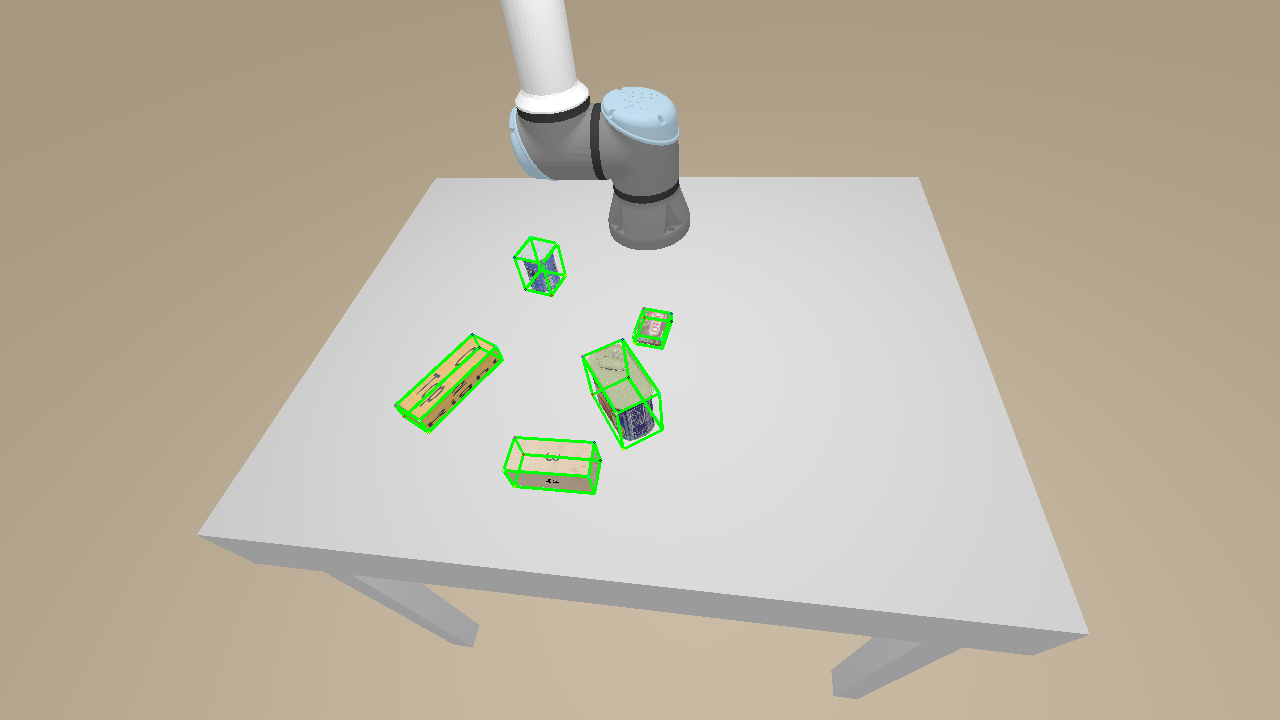

In [14]:
boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    utils.draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))

## Test data
Test data has everything but the poses. Testing data and training data are from the same distribution.

In [15]:
load_pickle("../data/pose_dataset/testing_data/v2.2/1-1-1_meta.pkl").keys()

dict_keys(['extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

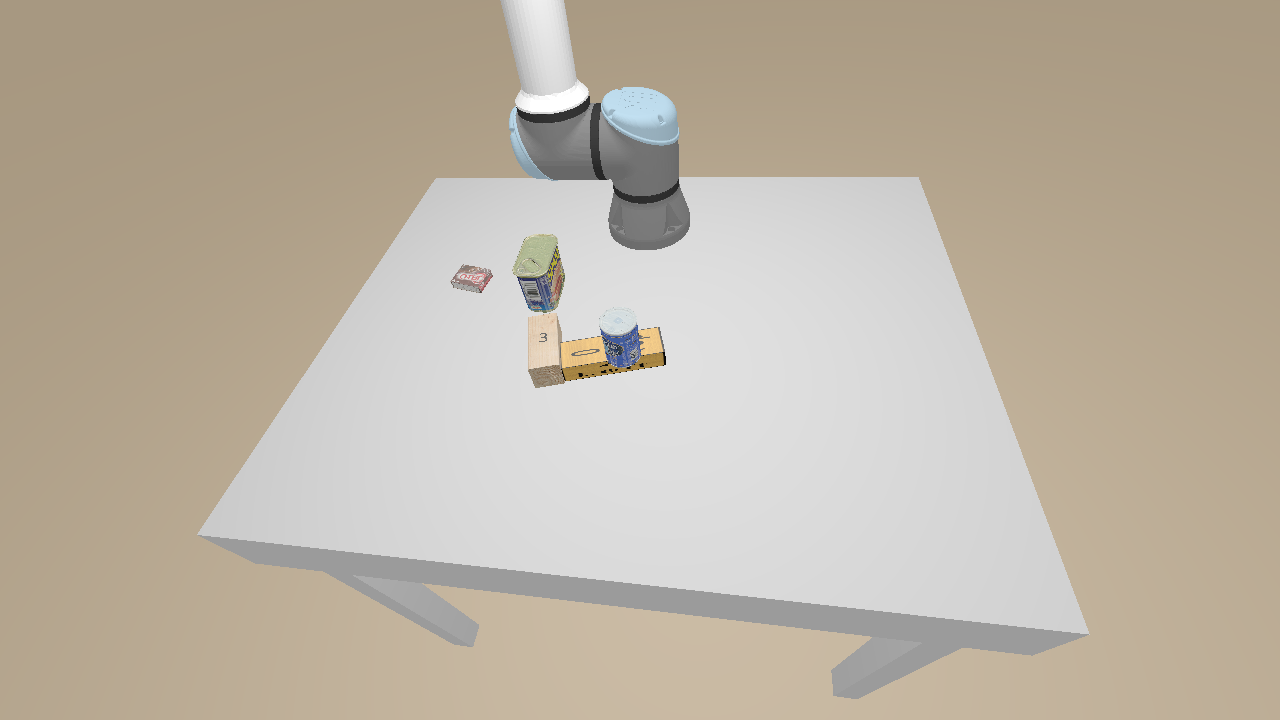

In [17]:
Image.open("../data/pose_dataset/testing_data/v2.2/1-1-1_color_kinect.png")